This notebook is an exploration of how to best code up the "overall" classifier, that classifies healthy from disease (regardless of disease)

In [2]:
import os
import sys
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import display

# Add util to the path
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.insert(0, src_dir)
import FileIO as fio
from util import collapse_taxonomic_contents_df, prep_classifier, cv_and_roc


The plan:

1. Read in all dataframes, rel abundance, collapse to genus
1. If dataframe has *Healthy* samples, keep for concatenation
1. Concatenate all dataframes - OTU and metadata
1. Query Healthy patients and not-healthy patients
1. Classify
    - make sure to keep classification labels
1. Visualize results

In [2]:
datadir = '../../data/clean_tables'
# Read in dfdict
dfdict = fio.read_dfdict_data(datadir)

Reading datasets...
cdi_youngster hiv_noguerajulian hiv_lozupone t1d_alkanani edd_singh asd_son crc_zeller ra_scher ibd_papa ob_zhu crc_baxter cdi_schubert par_scheperjans crc_wang ibd_gevers nash_zhu cdi_vincent ob_ross asd_kang mhe_zhang crc_chen ob_turnbaugh hiv_dinh crc_zackular ibd_morgan ob_zupancic ob_goodrich t1d_mejialeon ibd_willing nash_wong 
Reading datasets... Finished.


In [3]:
# Collapse to genus level and relabel samples
for dataset in dfdict:
    # Collapse to genus level and relabel samples with dataset ID
    df = dfdict[dataset]['df']
    df = collapse_taxonomic_contents_df(df, 'genus')
    df.index = [dataset + '-' + i for i in df.index]
    dfdict[dataset]['df'] = df
    
    # Also relabel indices in metadata
    meta = dfdict[dataset]['meta']
    meta.index = [dataset + '-' + i for i in meta.index]
    dfdict[dataset]['meta'] = meta

In [4]:
# Concatenate OTU tables and corresponding metadata
ignore_datasets = [d for d in dfdict if 'H' not in dfdict[d]['meta']['DiseaseState'].unique()]
# This data is a duplicate of nash_zhu
ignore_datasets += ['ob_zhu']
bigdf = pd.concat([dfdict[d]['df'] for d in dfdict if d not in ignore_datasets])
# Fill NaN's with zeros (i.e. unobserved OTUs)
bigdf = bigdf.fillna(0.0)
bigmeta = pd.concat([dfdict[d]['meta'] for d in dfdict if d not in ignore_datasets])
print(bigdf.shape)

(4366, 304)


In [5]:
# excludes: 'postFMT_CDI', None, ' '
diseases = ['CIRR', 'MHE', 'HIV', 'T1D', 'EDD', 'CRC', 'ASD', 'CDI',
            'PSA', 'RA', 'OB', 'OB-NASH', 'nonCRC', 'OW',
            'nonCDI', 'PAR', 'CD', 'UC', 'nonNASH-OB', 'NASH']
classes_list = [['H'], diseases]
[h_smpls, dis_smpls] = fio.get_samples(bigmeta, classes_list)

In [6]:
print(len(h_smpls), len(dis_smpls))

(1636, 2597)


In [7]:
bigmeta.loc[h_smpls, 'DiseaseState'].unique()

array(['H'], dtype=object)

In [8]:
bigmeta.loc[dis_smpls, 'DiseaseState'].unique()

array(['CIRR', 'MHE', 'HIV', 'T1D', 'EDD', 'CRC', 'ASD', 'CDI', 'PSA',
       'RA', 'nonCRC', 'OB', 'OW', 'nonCDI', 'PAR', 'CD', 'UC',
       'nonNASH-OB', 'NASH'], dtype=object)

In [9]:
random_state = 12345
rf, X, Y = prep_classifier(bigdf, h_smpls, dis_smpls, random_state)

In [10]:
results = cv_and_roc(rf, X, Y, num_cv=100, random_state=random_state)

In [11]:
results.keys()

['y_true',
 'y_prob',
 'mean_tpr',
 'mean_fpr',
 'test_fold',
 'conf_mat',
 'fisher_p',
 'roc_auc']

(array([[ 575, 1061],
       [ 294, 2303]]), 4.0992130110179797e-76, 0.75276382865170743)


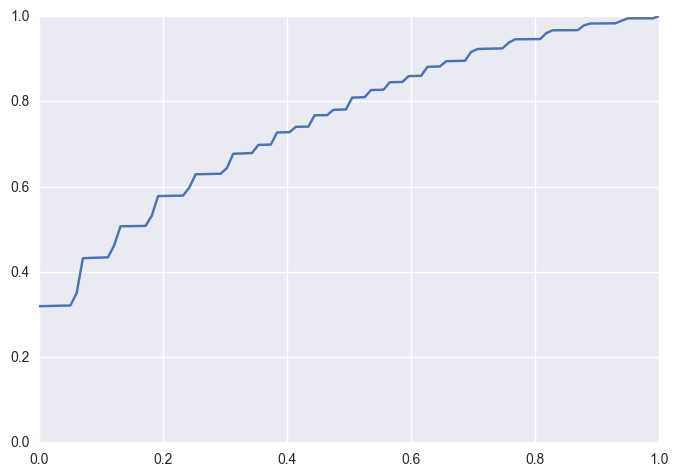

In [12]:
plt.plot(results['mean_fpr'], results['mean_tpr'])
plt.axis([0, 1, 0, 1])
print(results['conf_mat'], results['fisher_p'], results['roc_auc'])

Next step: look at classifier predictions by disease

In [13]:
preds = pd.DataFrame(columns=['y_true', 'y_prob'])
preds['y_true'] = results['y_true']
preds['y_prob'] = results['y_prob']
preds['sample'] = h_smpls + dis_smpls
preds = pd.merge(preds, bigmeta[['DiseaseState', 'dataset']], left_on='sample', right_index=True)
preds['disease_class'] = preds['dataset'].map(lambda x: x.split('_')[0])
preds['disease_class'] = preds['disease_class'].replace('edd', 'cdi')
preds.head()

,y_true,y_prob,sample,DiseaseState,dataset,disease_class
0,0,0.639,mhe_zhang-H001,H,mhe_zhang,mhe
1,0,0.494,mhe_zhang-H002,H,mhe_zhang,mhe
2,0,0.540,mhe_zhang-H003,H,mhe_zhang,mhe
3,0,0.782,mhe_zhang-H004,H,mhe_zhang,mhe
4,0,0.622,mhe_zhang-H005,H,mhe_zhang,mhe


In [14]:
g = 'nash_zhu'
subdf = preds.query('dataset == @g')
nash = pd.concat((subdf.query('DiseaseState == "NASH"'), subdf.query('DiseaseState == "H"')))
nash.query('y_true == 0').shape

(16, 6)

In [10]:
disease_colors = {'cdi': "#61AA60", #"#43b944", #green
                  'ibd': "#996CCE", #"#9c69db", #purple #"#64ac48", blueish?
                  'ob':  "#F0C948", #"#f0c540", #golden  "#c25abc", #?
                  'crc': "#F56484", # "#f11c4f", #red/pink    #"#9a963f",
                  'asd': "#6992cf", #blue "#7566c9", #blueish purple
                  't1d': "#c98746", #brown
                  'nash': "#4aac8b", #teal-ish
                  'mhe': "#cc436f", #dark pink
                  'hiv': "#B86958", #"#ca553b",#rusty red
                  'par': "#c07198", #dark pink}
                  'ra': "#d59847" #orange
                  }

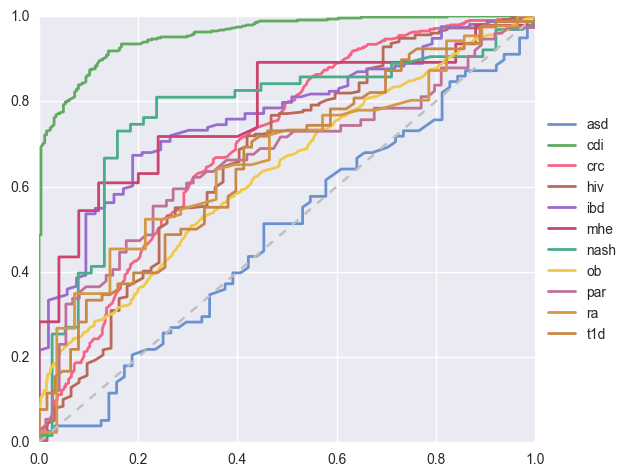

In [15]:
fig, ax = plt.subplots(1,1)
for g, subdf in preds.groupby('disease_class'):
    fpr, tpr, _ = roc_curve(subdf['y_true'], subdf['y_prob'])
    ax.plot(fpr, tpr, label=g, c=disease_colors[g], linewidth=2)
# plot y = x
ax.plot([0,1], [0,1], linestyle='--', color='0.75')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [16]:
## Look at this AUC vs. the single-disease AUC
fn_rf_results = '/Users/claire/github/microbiomeHD/data/analysis_results/rf_results.txt'
rf_results = pd.read_csv(fn_rf_results, sep='\t')
rf_results.head()

,mean_fpr,mean_tpr,roc_auc,fisher_p,dataset,H_smpls,dis_smpls,num_features
0,0.000000,0.542222,0.80119,0.016069,mhe_zhang,25,46,55
1,0.010101,0.542222,0.80119,0.016069,mhe_zhang,25,46,55
2,0.020202,0.542222,0.80119,0.016069,mhe_zhang,25,46,55
3,0.030303,0.542222,0.80119,0.016069,mhe_zhang,25,46,55
4,0.040404,0.542222,0.80119,0.016069,mhe_zhang,25,46,55


In [17]:
# Calculate disease-wise AUC from the full classifier
full_cls_auc = []
for g, subdf in preds.groupby('dataset'):
    fpr, tpr, _ = roc_curve(subdf['y_true'], subdf['y_prob'])
    full_cls_auc.append([g, auc(fpr, tpr)])
full_cls_auc = pd.DataFrame(full_cls_auc, columns=['dataset', 'auc_full_cls'])

aucs = pd.merge(rf_results[['dataset', 'roc_auc']].drop_duplicates(), full_cls_auc)
aucs['disease'] = aucs['dataset'].map(lambda x: x.split('_')[0])
aucs['disease'] = aucs['disease'].replace('edd', 'cdi')
aucs['colors'] = aucs['disease'].map(lambda x: disease_colors[x])
aucs.head()

,dataset,roc_auc,auc_full_cls,disease,colors
0,mhe_zhang,0.801190,0.779565,mhe,#cc436f
1,hiv_noguerajulian,0.669463,0.501722,hiv,#B86958
2,hiv_lozupone,0.923990,0.943144,hiv,#B86958
3,t1d_alkanani,0.710606,0.718022,t1d,#c98746
4,edd_singh,0.957783,0.941815,cdi,#61AA60


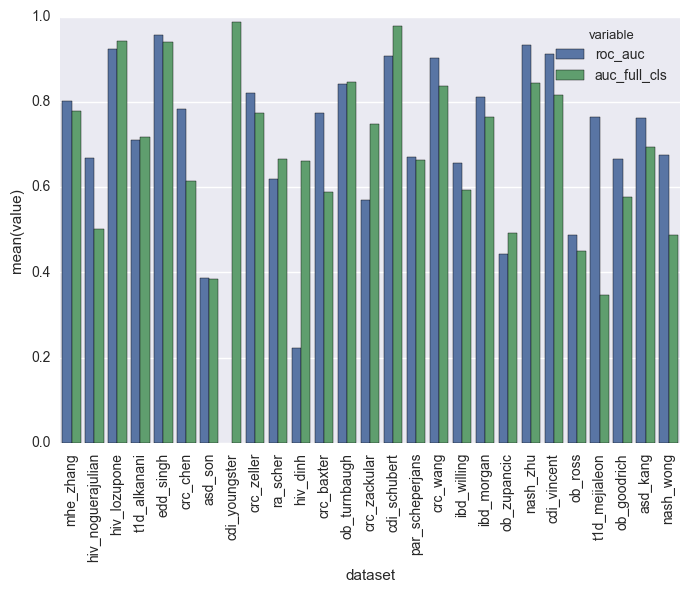

In [18]:
sns.barplot(x='dataset', y='value', hue='variable', data=pd.melt(aucs[['dataset', 'roc_auc', 'auc_full_cls']], id_vars='dataset'))
_ = plt.xticks(rotation=90)

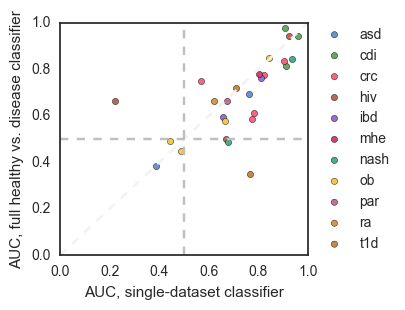

In [19]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0, 1], [0, 1], '--', c='0.95')
ax.plot([0.5, 0.5], [0, 1], '--', c='0.75')
ax.plot([0, 1], [0.5, 0.5], '--', c='0.75')
for g, subdf in aucs.groupby('disease'):
    ax.scatter(subdf['roc_auc'], subdf['auc_full_cls'], c=disease_colors[g], label=g)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('AUC, single-dataset classifier')
ax.set_ylabel('AUC, full healthy vs. disease classifier')
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('dataset_vs_full_aucs.png')

In [20]:
results.keys()

['y_true',
 'y_prob',
 'mean_tpr',
 'mean_fpr',
 'test_fold',
 'conf_mat',
 'fisher_p',
 'roc_auc']

# Leave one dataset out

Okay, this is cool - but what if the classifier is just first finding the dataset and then classifying healthy vs. disease?

Let's re-train a healthy vs. disease classifier in a leave-one-dataset-out fashion.


In [37]:
## Read in all datasets and concatenate
dfdict = fio.read_dfdict_data(datadir)

# Collapse to genus level and relabel samples
for dataset in dfdict:
    # Collapse to genus level and relabel samples with dataset ID
    df = dfdict[dataset]['df']
    df = collapse_taxonomic_contents_df(df, 'genus')
    df.index = [dataset + '-' + i for i in df.index]
    dfdict[dataset]['df'] = df
    
    # Also relabel indices in metadata
    meta = dfdict[dataset]['meta']
    meta.index = [dataset + '-' + i for i in meta.index]
    dfdict[dataset]['meta'] = meta

# Concatenate OTU tables and corresponding metadata
ignore_datasets = [d for d in dfdict if 'H' not in dfdict[d]['meta']['DiseaseState'].unique()]
# This data is a duplicate of nash_zhu
ignore_datasets += ['ob_zhu']

bigdf = pd.concat([dfdict[d]['df'] for d in dfdict if d not in ignore_datasets])
# Fill NaN's with zeros (i.e. unobserved OTUs)
bigdf = bigdf.fillna(0.0)
bigmeta = pd.concat([dfdict[d]['meta'] for d in dfdict if d not in ignore_datasets])


Reading datasets...
cdi_youngster hiv_noguerajulian hiv_lozupone t1d_alkanani edd_singh asd_son crc_zeller ra_scher ibd_papa ob_zhu crc_baxter cdi_schubert par_scheperjans crc_wang ibd_gevers nash_zhu cdi_vincent ob_ross asd_kang mhe_zhang crc_chen ob_turnbaugh hiv_dinh crc_zackular ibd_morgan ob_zupancic ob_goodrich t1d_mejialeon ibd_willing nash_wong 
Reading datasets... Finished.


In [38]:
bigdf.shape

(4366, 304)

In [39]:
random_state = 12345

# Get healthy and disease samples
classes_list = fio.get_classes(bigmeta)
classes_list[0] = ['H']
classes_list[1].append('nonCDI')
[h_smpls, dis_smpls] = fio.get_samples(bigmeta, classes_list)

datasets = [d for d in dfdict.keys() if d not in ignore_datasets]
all_results = []
for d in datasets:
    print(d)
    train_h = [i for i in h_smpls if not i.startswith(d)]
    train_dis = [i for i in dis_smpls if not i.startswith(d)]
    rf, X_train, Y_train = prep_classifier(bigdf, train_h, train_dis, random_state)
    
    test_h = [i for i in h_smpls if i.startswith(d)]
    test_dis = [i for i in dis_smpls if i.startswith(d)]
    _, X_test, Y_test = prep_classifier(bigdf, test_h, test_dis, random_state)
    
    # Train
    rf = rf.fit(X_train, Y_train)
    # Test
    probs = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(Y_test, probs)
    roc_auc = auc(fpr, tpr)

    print('train datasets: {}, test datasets: {}'.format(
        len(set([i.split('-')[0] for i in train_h])),
        len(set([i.split('-')[0] for i in test_h]))))
    
    results = pd.DataFrame.from_dict(dict(zip(['dataset', 'fpr', 'tpr', 'auc'],
                                                (d, fpr, tpr, roc_auc))))
    all_results.append(results)
df_all_results = pd.concat(all_results)
df_all_results.head()

mhe_zhang
train datasets: 26, test datasets: 1
hiv_noguerajulian
train datasets: 26, test datasets: 1
hiv_lozupone
train datasets: 26, test datasets: 1
t1d_alkanani
train datasets: 26, test datasets: 1
edd_singh
train datasets: 26, test datasets: 1
crc_chen
train datasets: 26, test datasets: 1
asd_son
train datasets: 26, test datasets: 1
cdi_youngster
train datasets: 26, test datasets: 1
crc_zeller
train datasets: 26, test datasets: 1
ra_scher
train datasets: 26, test datasets: 1
hiv_dinh
train datasets: 26, test datasets: 1
crc_baxter
train datasets: 26, test datasets: 1
ob_turnbaugh
train datasets: 26, test datasets: 1
crc_zackular
train datasets: 26, test datasets: 1
cdi_schubert
train datasets: 26, test datasets: 1
par_scheperjans
train datasets: 26, test datasets: 1
crc_wang
train datasets: 26, test datasets: 1
ibd_willing
train datasets: 26, test datasets: 1
ibd_morgan
train datasets: 26, test datasets: 1
ob_zupancic
train datasets: 26, test datasets: 1
nash_zhu
train datasets: 2

,auc,dataset,fpr,tpr
0,0.753478,mhe_zhang,0.00,0.021739
1,0.753478,mhe_zhang,0.00,0.217391
2,0.753478,mhe_zhang,0.04,0.217391
3,0.753478,mhe_zhang,0.04,0.478261
4,0.753478,mhe_zhang,0.12,0.500000


In [40]:
## Look at this AUC vs. the single-disease AUC
fn_rf_results = '/Users/claire/github/microbiomeHD/data/analysis_results/rf_results.txt'
rf_results = pd.read_csv(fn_rf_results, sep='\t')

aucs_datasetout = pd.merge(rf_results[['dataset', 'roc_auc']].drop_duplicates(), df_all_results[['dataset', 'auc']].drop_duplicates())
aucs_datasetout = aucs_datasetout.rename(columns={'auc': 'auc_full', 'roc_auc': 'auc_dataset'})
aucs_datasetout['disease'] = aucs_datasetout['dataset'].map(lambda x: x.split('_')[0])
aucs_datasetout['disease'] = aucs_datasetout['disease'].replace('edd', 'cdi')
aucs_datasetout.sort_values(by='auc_dataset')

,dataset,auc_dataset,auc_full,disease
10,hiv_dinh,0.221717,0.730159,hiv
6,asd_son,0.386276,0.461672,asd
19,ob_zupancic,0.442344,0.536097,ob
22,ob_ross,0.486797,0.515593,ob
13,crc_zackular,0.569192,0.792778,crc
9,ra_scher,0.620076,0.565199,ra
17,ibd_willing,0.657239,0.668254,ibd
24,ob_goodrich,0.666916,0.571015,ob
1,hiv_noguerajulian,0.669463,0.455022,hiv
15,par_scheperjans,0.671944,0.550676,par


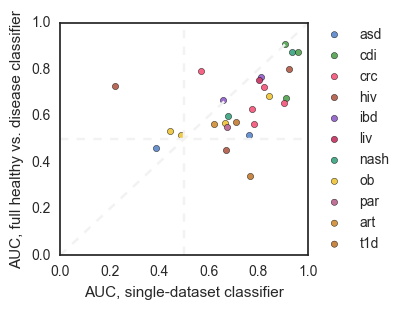

In [41]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0, 1], [0, 1], '--', c='0.95')
ax.plot([0.5, 0.5], [0, 1], '--', c='0.95')
ax.plot([0, 1], [0.5, 0.5], '--', c='0.95')

for g, subdf in aucs_datasetout.groupby('disease'):
    if g == 'mhe':
        label = 'liv'
    elif g == 'ra':
        label = 'art'
    else:
        label = g
    ax.scatter(subdf['auc_dataset'], subdf['auc_full'], c=disease_colors[g], label=label)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('AUC, single-dataset classifier')
ax.set_ylabel('AUC, full healthy vs. disease classifier')
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('leave_one_dataset_out.png')

# Leave one disease out


In [30]:
## Read in all datasets and concatenate
datadir = '../../data/clean_tables'
dfdict = fio.read_dfdict_data(datadir)

# Collapse to genus level and relabel samples
for dataset in dfdict:
    # Collapse to genus level and relabel samples with dataset ID
    df = dfdict[dataset]['df']
    df = collapse_taxonomic_contents_df(df, 'genus')
    
    if dataset == 'edd_singh':
        df.index = ['cdi_singh-' + i for i in df.index]
    else:  
        df.index = [dataset + '-' + i for i in df.index]
    dfdict[dataset]['df'] = df
    
    # Also relabel indices in metadata
    meta = dfdict[dataset]['meta']
    if dataset == 'edd_singh':
        meta.index = ['cdi_singh-' + i for i in meta.index]
    else:
        meta.index = [dataset + '-' + i for i in meta.index]
    dfdict[dataset]['meta'] = meta

# Concatenate OTU tables and corresponding metadata
ignore_datasets = [d for d in dfdict if 'H' not in dfdict[d]['meta']['DiseaseState'].unique()]
# This data is a duplicate of nash_zhu
ignore_datasets += ['ob_zhu']

bigdf = pd.concat([dfdict[d]['df'] for d in dfdict if d not in ignore_datasets])
# Fill NaN's with zeros (i.e. unobserved OTUs)
bigdf = bigdf.fillna(0.0)
bigmeta = pd.concat([dfdict[d]['meta'] for d in dfdict if d not in ignore_datasets])

Reading datasets...
cdi_youngster hiv_noguerajulian hiv_lozupone t1d_alkanani edd_singh asd_son crc_zeller ra_scher ibd_papa ob_zhu crc_baxter cdi_schubert par_scheperjans crc_wang ibd_gevers nash_zhu cdi_vincent ob_ross asd_kang mhe_zhang crc_chen ob_turnbaugh hiv_dinh crc_zackular ibd_morgan ob_zupancic ob_goodrich t1d_mejialeon ibd_willing nash_wong 
Reading datasets... Finished.


In [31]:
print(set([i.split('_')[0] for i in bigdf.index]))

set(['t1d', 'par', 'hiv', 'mhe', 'ibd', 'cdi', 'ob', 'crc', 'ra', 'asd', 'nash'])


In [32]:
random_state = 12345

# Get healthy and disease samples
classes_list = fio.get_classes(bigmeta)
classes_list[0] = ['H']
classes_list[1].append('nonCDI')
[h_smpls, dis_smpls] = fio.get_samples(bigmeta, classes_list)

diseases = list(set([i.split('_')[0] for i in bigdf.index]))
all_results = []
for d in diseases:
    print(d)
    train_h = [i for i in h_smpls if not i.startswith(d)]
    train_dis = [i for i in dis_smpls if not i.startswith(d)]
    rf, X_train, Y_train = prep_classifier(bigdf, train_h, train_dis, random_state)
    
    test_h = [i for i in h_smpls if i.startswith(d)]
    test_dis = [i for i in dis_smpls if i.startswith(d)]
    _, X_test, Y_test = prep_classifier(bigdf, test_h, test_dis, random_state)
    
    # Train
    rf = rf.fit(X_train, Y_train)
    # Test
    probs = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(Y_test, probs)
    roc_auc = auc(fpr, tpr)

    print('train datasets: {}, test datasets: {}'.format(
        len(set([i.split('-')[0] for i in train_h])),
        len(set([i.split('-')[0] for i in test_h]))))
    
    results = pd.DataFrame.from_dict(dict(zip(['disease', 'fpr', 'tpr', 'auc'],
                                                (d, fpr, tpr, roc_auc))))
    all_results.append(results)
df_all_results_dis = pd.concat(all_results)
df_all_results_dis.head()

t1d
train datasets: 25, test datasets: 2
par
train datasets: 26, test datasets: 1
hiv
train datasets: 24, test datasets: 3
mhe
train datasets: 26, test datasets: 1
ibd
train datasets: 25, test datasets: 2
cdi
train datasets: 23, test datasets: 4
ob
train datasets: 23, test datasets: 4
crc
train datasets: 22, test datasets: 5
ra
train datasets: 26, test datasets: 1
asd
train datasets: 25, test datasets: 2
nash
train datasets: 25, test datasets: 2


,auc,disease,fpr,tpr
0,0.494912,t1d,0.000000,0.012821
1,0.494912,t1d,0.000000,0.038462
2,0.494912,t1d,0.015873,0.038462
3,0.494912,t1d,0.015873,0.076923
4,0.494912,t1d,0.063492,0.076923


In [33]:
## Look at this AUC vs. the single-disease AUC
fn_rf_results = '/Users/claire/github/microbiomeHD/data/analysis_results/rf_results.txt'
rf_results = pd.read_csv(fn_rf_results, sep='\t')
rf_results['disease'] = rf_results['dataset'].map(lambda x: x.split('_')[0])
mean_auc = rf_results.groupby('disease').mean()['roc_auc']
mean_auc = pd.DataFrame(mean_auc)
mean_auc = mean_auc.rename(columns={'roc_auc': 'mean_dataset_auc'})
mean_auc.head()

,mean_dataset_auc
disease,
asd,0.574746
cdi,0.910562
crc,0.770108
edd,0.957783
hiv,0.605057


In [34]:
aucs = df_all_results_dis[['disease', 'auc']].drop_duplicates()
aucs.index = aucs['disease']
aucs = aucs.rename(columns={'auc': 'auc_leaveout'})
aucs = pd.concat((aucs, mean_auc), axis=1).dropna()
aucs

,disease,auc_leaveout,mean_dataset_auc
asd,asd,0.453626,0.574746
cdi,cdi,0.739327,0.910562
crc,crc,0.571546,0.770108
hiv,hiv,0.467321,0.605057
ibd,ibd,0.673203,0.755042
mhe,mhe,0.753478,0.801190
nash,nash,0.580332,0.804966
ob,ob,0.676042,0.660614
par,par,0.550676,0.671944
ra,ra,0.565199,0.620076


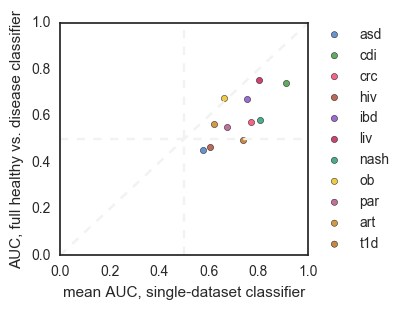

In [36]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0, 1], [0, 1], '--', c='0.95')
ax.plot([0.5, 0.5], [0, 1], '--', c='0.95')
ax.plot([0, 1], [0.5, 0.5], '--', c='0.95')

for g, subdf in aucs.groupby('disease'):
    if g == 'mhe':
        label = 'liv'
    elif g == 'ra':
        label = 'art'
    else:
        label = g
    ax.scatter(subdf['mean_dataset_auc'], subdf['auc_leaveout'], c=disease_colors[g], label=label)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('mean AUC, single-dataset classifier')
ax.set_ylabel('AUC, full healthy vs. disease classifier')
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.tight_layout()
fig.savefig('leave_one_disease_out.png')

In [24]:
from scipy.stats import pearsonr

pearsonr(aucs['auc_leaveout'], aucs['mean_dataset_auc'])

(0.69916185007404275, 0.016656582760971005)